# MVPA 1: Pattern Classification

This tutorial runs a simple pattern classification (decoding) analysis on the localizer data. We will be using many of the tools we've used so far, and also [scikit-learn](https://scikit-learn.org/stable/index.html) for pattern classification. Scikit-learn is an amazing machine learning package that is widely used. We will import some classifiers as well as ways to train these algorithms on our data.

In [1]:
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, LeaveOneGroupOut

import nibabel as nib
from nilearn.input_data import MultiNiftiMasker, NiftiMasker
from nilearn import image
from nilearn.plotting import plot_roi

%matplotlib inline
pd.options.mode.chained_assignment = None 

## 1. Setting up our ROI mask

Like in many decoding analyses, we'll look at patterns of voxels from a predetermined ROI (there are exceptions to this, see Searchlight). 

For examples sake, we'll use SSc. Remember last time we showed that SSc had similar mean activity for Arm, Grasp, and Touch. To show this, we tossed away a lot of information by averaging across voxels. Pattern classification let's us ask a more refined question: are the _patterns_ of voxel activity in SSc different between these conditions, despite their similarities in mean? Here, we are making use of all activity in the ROI. 

First, let's load in our mask. 

In [2]:
roi = nib.load('L_SSc.nii.gz')
roi.shape

(91, 109, 91)

This mask is in MNI space (as is our data), but is in 2mm isovoxel. Our data, meanwhile, is in 3x3x4 MNI space. Let's load in our functional images and check:

In [3]:
# get all motor task runs of one subject
glob_template = ('data/derivatives/fmriprep/sub-03/func/'
                '*task-motor*MNI152NLin2009cAsym*preproc_bold.nii.gz')
func_data = glob.glob(glob_template)

# reorder these based on run number 
func_imgs = sorted(list(func_data))
func_imgs

['data/derivatives/fmriprep/sub-03/func/sub-03_task-motor_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz',
 'data/derivatives/fmriprep/sub-03/func/sub-03_task-motor_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz',
 'data/derivatives/fmriprep/sub-03/func/sub-03_task-motor_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz',
 'data/derivatives/fmriprep/sub-03/func/sub-03_task-motor_run-04_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz']

In [4]:
nib.load(func_imgs[0]).shape

(65, 77, 49, 350)

Let's resample our mask so that it has the same number of voxels as our functional data. We are doing this so that we analyze data in according to the functional resolution rather than the mask resolution. This means fewer, and less redundant, voxels (no upsampling to mask resolution) for our pattern classifier to use. 

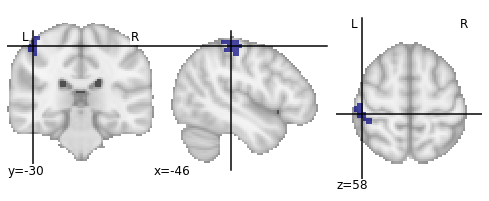

In [5]:
# `nearest` ensures that voxels are either 0 or 1 after interpolation
roi = image.resample_to_img('L_SSc.nii.gz', func_imgs[0], interpolation='nearest')
plot_roi(roi)

## 2. Extracting voxel data from our ROI

Now we need to extract voxel data from our ROI. We can use `MultiNiftiMasker` to do this, which lets us pass in a list of functional (unlike `NiftiMasker`). We'll apply some temporal processing along with standardization, and we'll regress out head motion. Let's get those regressors first:

In [6]:
glob_template = ('data/derivatives/fmriprep/sub-03/func/'
                '*task-motor*confounds_regressors.tsv')
conf_files = glob.glob(glob_template)

# reorder these based on run number
conf_files = sorted(list(conf_files))

# load only the 6 motion parameters into python
motion_params = []
for conf in conf_files:
    conf_data = pd.read_table(conf, usecols=['trans_x', 'trans_y', 'trans_z', 'rot_x', 'rot_y', 'rot_z'])
    motion_params.append(conf_data.values)


Now we can extract our data:

In [7]:
masker = MultiNiftiMasker(mask_img=roi, high_pass=.01, detrend=True, t_r=2, standardize=True)

func_data = masker.fit_transform(func_imgs, confounds=motion_params)

Now let's see what we have using matplotlib's `imshow`. This will let us plot the ROI's voxels during one functional run. 

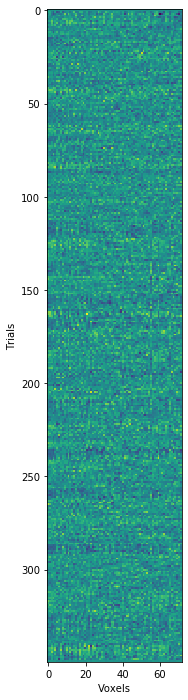

In [8]:
fig, ax = plt.subplots(figsize=(3, 12))
ax.imshow(func_data[0])
ax.set(xlabel='Voxels', ylabel='Trials');

## 3. Getting trial patterns 

Now we need to only **one pattern of voxels per trial**. There are lots of ways of doing this, and several papers that explore how to apply GLM's in order to estimate single trial patterns (e.g., see the excellent work by Mumford et al: [1](https://www.sciencedirect.com/science/article/abs/pii/S1053811911010081), [2](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0126255)). 

For the sake of an excercise/tutorial, we will instead take a pattern roughly corresponding to the peak BOLD activity in a 20s block. This is not an _ideal_ way because we're selecting one timepoint of voxels (so there will be lots of noise), but nevertheless a simple way. 

So, we have to a) read in the event files, b) select a volume after block/trial onset, and c) use that volume number as a row index for the voxel array above. 

Let's get our event files first:

In [9]:
event_files = glob.glob('data/task-motor*events.tsv')
event_files = sorted(list(event_files))

events = []
for i, ev in enumerate(event_files):
    events.append(pd.read_table(ev))

# show the first 10 rows
events[0].head(10)

,onset,duration,trial_type,trial
0,20,20,Speech,1
1,40,20,Arm,2
2,60,20,Grasp,3
3,80,20,Finger,4
4,100,20,Eye,5
5,120,20,Toes,6
6,140,20,Mouth,7
7,160,20,Touch,8
8,180,20,Arm,9
9,200,20,Finger,10


Now let's create a function that gives us the volume (row) we wish to use for pattern classification. 

In [10]:
def get_trial_volumes(df, shift=5):
    
    df = df.copy()
    # convert seconds to volume
    df['onset_vols'] = df['onset'] / 2
    
    # get volume corresponding to onset + shift. Default is
    # 5 to approximate peak reponse for a 20s block. We essentially
    # just want something representative of the entire block
    df['trial_vol'] = df['onset_vols'] + shift
    
    # convert to integers rather than floats
    df['trial_vol'] = df['trial_vol'].astype(int)
    
    # returns a dataframe with 3 columns
    return df[['trial', 'trial_type', 'trial_vol']]

Let's use one event file to see what our function does:

In [13]:
first_run_trials = get_trial_volumes(events[0])
first_run_trials

,trial,trial_type,trial_vol
0,1,Speech,15
1,2,Arm,25
2,3,Grasp,35
3,4,Finger,45
4,5,Eye,55
5,6,Toes,65
6,7,Mouth,75
7,8,Touch,85
8,9,Arm,95
9,10,Finger,105


But typically, we only want two conditions of interests for our classifier in MVPA (i.e. binary classification). So we actually need to pull out just the patterns belonging to these conditions. 

In [14]:
arm_vs_touch = first_run_trials.query("trial_type == 'Arm' or trial_type == 'Touch'")
arm_vs_touch

,trial,trial_type,trial_vol
1,2,Arm,25
7,8,Touch,85
8,9,Arm,95
11,12,Touch,125
20,21,Arm,225
22,23,Touch,245
25,26,Touch,275
27,28,Arm,295


Selecting those volumes and plotting the voxels:

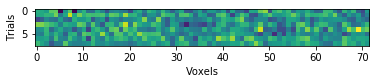

In [15]:
first_run = func_data[0]
trial_voxels = first_run[arm_vs_touch['trial_vol'], :]

fig, ax = plt.subplots()
ax.imshow(trial_voxels)
ax.set(xlabel='Voxels', ylabel='Trials');

Now, I've created a handy function that does this across runs. It iterates through each run, and gives you a final voxel array and row labels.

In [16]:
def get_trial_voxels(voxels, task_events, conditions):
    # iterate through data and event_files in tandem
    
    cond1, cond2 = conditions
    
    trials_list = []
    data_list = []
    for i, (vox, ev) in enumerate(zip(voxels, task_events)):
        
        # get the trial patterns for specific conditions we want to use
        trials = get_trial_volumes(ev)
        trials = trials.query("trial_type == @cond1 or trial_type == @cond2")
        data = vox[trials.loc[:, 'trial_vol'], :]
        
        # get condition labels from trial type column
        trials.loc[:, 'run'] = i
        
        trials_list.append(trials)
        data_list.append(data)
    
    # concatenate lists to create single dataframe and voxel array
    trials = pd.concat(trials_list)
    data = np.vstack(data_list)
        
    return trials, data

We can run it, and it returns information on the trial (trial type, number, etc) and the voxels:

In [17]:
info, voxels = get_trial_voxels(func_data, events, ['Arm', 'Touch'])
info

,trial,trial_type,trial_vol,run
1,2,Arm,25,0
7,8,Touch,85,0
8,9,Arm,95,0
11,12,Touch,125,0
20,21,Arm,225,0
22,23,Touch,245,0
25,26,Touch,275,0
27,28,Arm,295,0
4,5,Touch,55,1
7,8,Arm,85,1


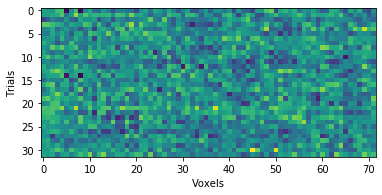

In [18]:
fig, ax = plt.subplots()
ax.imshow(voxels)
ax.set(xlabel='Voxels', ylabel='Trials');

## 4. Running a classifier

Now we can use [scikit learn](https://scikit-learn.org/stable/index.html) to train and evaluate our model. First, we need to define our classifier. At the top, we imported `SVC`, which is support vector machine (SVM) classifier, and `LogisticRegression`, which is a regularized logistic regression classifier. These are probably the two most popular algorithms in decoding studies as the tend to perform well (SVM generally moreso than logistic regression). 


**SVMs:**  
A SVM essentially tries to find a hyperplane between classes with maximal margins. The margins are defined by the closest points to the hyperplane. This is easy to visualize in with two features (e.g., two voxels):

![](https://scikit-learn.org/stable/_images/sphx_glr_plot_separating_hyperplane_0011.png)

The figure above is taken from the excellent scikit-learn documentation: https://scikit-learn.org/stable/modules/svm.html#svm-classification.

In our case, were trying to find a hyperplane in _N_-dimensional space, where _N_ = number of voxels. SVMs perform very well on the data, as they're fairly robust to noise and redundancy.

**Logistic Regression:**  
Scikit learn implements a regularized ($\ell_2$-norm) logistic regression by default (which differs from your standard logistic regression model that has no regularization). Logistic regression essentially transforms the output of a linear regression using a sigmoid function, which produces probabilities between 0 and 1. Binary classification is just done by taking probability values below or above 50% and assigning them as 0 or 1, respectively. 


![](https://scikit-learn.org/stable/_images/sphx_glr_plot_logistic_001.png)

The graph above is created by this example: https://scikit-learn.org/stable/auto_examples/linear_model/plot_logistic.html#sphx-glr-auto-examples-linear-model-plot-logistic-py

See also: https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

In [19]:
svm = SVC(kernel='linear')
logreg = LogisticRegression()

**Cross Validation**

Next, we need to set up a way to train our model and then evaluate it. In supervised machine learning, models are first fit on training data. This process essentially lets the model map input data to labels/outcomes. Then the trained models are tested on unseen data to try and predict their labels/outcomes. In our case, we will train our model on voxel data from two conditions, and then use a held-out, unseen test set to try and predict the condition of those data based on their voxels.  

We can do this using [cross validation](https://scikit-learn.org/stable/modules/cross_validation.html). Cross validation is an iterative process in which we split our data into train and test folds. Each iteration involves a unique split, thus letting us train and test across all of our data. For each iteration, we obtain a classification accuracy, and we can compute an average accuracy across iterations. 

![](https://upload.wikimedia.org/wikipedia/commons/thumb/b/b5/K-fold_cross_validation_EN.svg/1280px-K-fold_cross_validation_EN.svg.png)

Scikit-learn makes this process increadibly simple using `cross_val_score`. This does everything for us. All we need to do is give it our data, our model, and how we want to cross validate and score the procedure (e.g., classification accuracy).

So, let's make sure we're clear on our data. Lets set up `X` and `y`, which is typical notation you'll see in scikit-learn docs and elsewhere. 

In [20]:
info, X = get_trial_voxels(func_data, events, ['Arm', 'Touch'])

In [21]:
y = info['trial_type'].tolist()
y

['Arm',
 'Touch',
 'Arm',
 'Touch',
 'Arm',
 'Touch',
 'Touch',
 'Arm',
 'Touch',
 'Arm',
 'Arm',
 'Touch',
 'Touch',
 'Arm',
 'Touch',
 'Arm',
 'Arm',
 'Touch',
 'Arm',
 'Touch',
 'Arm',
 'Touch',
 'Touch',
 'Arm',
 'Touch',
 'Arm',
 'Arm',
 'Touch',
 'Touch',
 'Arm',
 'Touch',
 'Arm']

Now let's set up our cross validator. How do we determine our splits? People typically use _K_-fold cross validation shown above, but in neuroimaging, we often use _leave-one-run-out_ cross validation. This essentially lets our functional runs determine our folds, and ensures that our train/test folds are completely independent from one another (which reduces overfitting by reducing shared variance between train and test sets). 

Let's run `cross_val_score` and give it our model and the data. Note that `groups` is used to define our functional runs (i.e. folds). 

In [22]:
accuracies = cross_val_score(svm, X, y, groups=info['run'], cv=LeaveOneGroupOut())
accuracies

array([0.625, 0.5  , 0.625, 0.75 ])

In [23]:
np.mean(accuracies)

0.625

## 5. Group Analysis

We can put everything we've done into one big for-loop that iterates across subjects. For each subject, we'll run the pattern classification pipeline above and take their mean accuracy. Then we can show these accuracies at the group level.

In [25]:
# set up parameters
subject_numbers = ['01', '02', '03', '04', '05', '06', '07', '08']
columns = ['trans_x', 'trans_y', 'trans_z', 'rot_x', 'rot_y', 'rot_z']
roi = 'L_SSc.nii.gz'
conditions = ['Arm', 'Touch']
clf = SVC(kernel='linear')

# resample our mask
roi = image.resample_to_img(roi, func_imgs[0], interpolation='nearest')

results = []
for subject in subject_numbers:
    
    ## 1. Get the functional images in order
    glob_template = (f'data/derivatives/fmriprep/sub-{subject}/func/'
                     '*task-motor*MNI152NLin2009cAsym*preproc_bold.nii.gz')
    func_imgs = glob.glob(glob_template)
    func_imgs = sorted(list(func_imgs))
    
    # 2. Get the regressors
    glob_template = (f'data/derivatives/fmriprep/sub-{subject}/func/'
                      '*task-motor*confounds_regressors.tsv')
    conf_files = glob.glob(glob_template)
    # put files in order
    conf_files = sorted(list(conf_files))

    # load only the 6 motion parameters
    motion_params = []
    for conf in conf_files:
        conf_data = pd.read_table(conf, usecols=columns)
        motion_params.append(conf_data.values)
        
    # extract data
    masker = MultiNiftiMasker(mask_img=roi, high_pass=.01, detrend=True, t_r=2, 
                              standardize=True)
    func_data = masker.fit_transform(func_imgs, confounds=motion_params)
    
    # get trial patterns with trial information
    info, voxels = get_trial_voxels(func_data, events, conditions)
    
    # run cross validation
    X = voxels
    y = info['trial_type'].tolist()
    accuracies = cross_val_score(clf, X, y, groups=info['run'], cv=LeaveOneGroupOut())
    
    # save subject mean accuracy
    results.append(np.mean(accuracies))
    


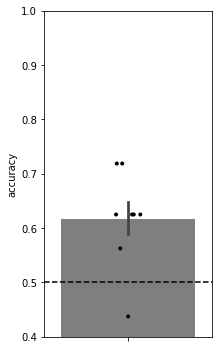

In [26]:
# put into dataframe that's convenient for seaborn
df = pd.DataFrame({'x': '', 'accuracy': results})

fig, ax = plt.subplots(figsize=(3, 6))
sns.barplot('x', 'accuracy', data=df, ci=68, ax=ax, color='C7')
sns.stripplot('x', 'accuracy', data=df, ax=ax, color='k',
              edgecolor='k', marker='o', size=4)
ax.set(ylim=(.4, 1), xlabel='')
ax.axhline(.5, c='k', ls='--')